# Grand Tack Hypothesis Simulation with AMUSE

This notebook simulates the Grand Tack model of early Solar System evolution, where Jupiter and Saturn's migration shaped the inner Solar System.

**Based on Walsh et al. (2011) Nature 475, 206-209**  
*"A low mass for Mars from Jupiter's early gas-driven migration"*

**And Raymond & Morbidelli (2014) review**

## Scientific Background

The Grand Tack model explains several puzzling features of our Solar System:
- **Mars' small mass** (~0.1 M_Earth instead of ~1 M_Earth expected)
- **Asteroid belt structure** (truncated at ~1 AU on inner edge)
- **Compositional dichotomy** (S-type vs C-type asteroids, NC vs CC meteorites)
- **Terrestrial planet formation timescale** (30-50 Myr)

### Key Evolutionary Stages (Walsh et al. 2011):

1. **Jupiter forms first** at ~3.5 AU, reaches ~1 M_Jupiter
2. **Inward Type II migration** - Jupiter migrates to ~1.5 AU in ~100,000 years
   - Type II migration in gas disk: da/dt = -2a/t_mig
   - Truncates inner disk at ~1 AU
3. **Saturn forms** at ~4-4.5 AU with initial mass ~0.3 M_Jupiter  
4. **Saturn migrates inward faster** - lower mass = faster Type II migration
5. **3:2 Resonance capture** - Saturn catches Jupiter, locks in 3:2 MMR
6. **Outward migration** - resonant pair migrates outward together
7. **Final positions** - Jupiter ~5.2 AU, Saturn ~9.5 AU

### Key Physics:
- **Type II migration timescale**: ~10^5 years (disk-dependent)
- **Mass ratio**: Saturn/Jupiter mass ratio affects migration rates
- **Resonance locking**: Period ratio P_Sat/P_Jup = 1.5
- **Disk dissipation**: Migration slows as disk evaporates over ~1-3 Myr

### Simulation Goals:
- Reproduce Jupiter's "tack" at 1.5 AU
- Demonstrate 3:2 resonance capture mechanism
- Track ~700 kyr of migration
- Validate final orbital architecture

In [11]:
%%bash
# Check and install required AMUSE components
PACKAGES="mpi4py amuse-framework amuse-huayno"
pip show amuse-devel && exit 0
for package in ${PACKAGES}
do
  pip show ${package} || pip install ${package}
done

Name: amuse-devel
Version: 2023.5.2.dev101+g93390091c
Summary: The Astrophysical Multipurpose Software Environment
Home-page: http://www.amusecode.org/
Author: The AMUSE team
Author-email: info@amusecode.org
License: Apache License 2.0
Location: /Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages
Editable project location: /Users/zoutongshen/amuse-src
Requires: docutils, h5py, numpy, pip, pytest, setuptools, setuptools_scm, wheel
Required-by: 


In [12]:
# AMUSE optimizations for notebook environment
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"] = "true"

from amuse.support import options
options.GlobalOptions.instance().override_value_for_option("polling_interval_in_milliseconds", 10)

## 1. Setup and Imports

In [23]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import time as pytime

from amuse.units import units, constants, nbody_system
from amuse.datamodel import Particles
from amuse.community.huayno.interface import Huayno
from amuse.ext.orbital_elements import orbital_elements_from_binary, new_binary_from_orbital_elements
from amuse.couple import bridge

print("AMUSE modules loaded successfully!")
print(f"Running Grand Tack simulation based on Walsh et al. (2011) Nature")
print(f"Key corrections from literature:")
print(f"  - Migration timescale: 100 kyr (not 50 kyr)")
print(f"  - Type II migration: da/dt = -2a/t_mig (factor of 2)")
print(f"  - Mass-dependent migration: faster for lower-mass Saturn")
print(f"  - Eccentricity damping: 10 orbital periods (conservative)")

AMUSE modules loaded successfully!
Running Grand Tack simulation based on Walsh et al. (2011) Nature
Key corrections from literature:
  - Migration timescale: 100 kyr (not 50 kyr)
  - Type II migration: da/dt = -2a/t_mig (factor of 2)
  - Mass-dependent migration: faster for lower-mass Saturn
  - Eccentricity damping: 10 orbital periods (conservative)


## 2. Define Simulation Parameters

Following the Grand Tack model specifications from the literature.

In [24]:
# =============================================================================
# GRAND TACK PARAMETERS (from Raymond & Morbidelli 2014)
# =============================================================================

# Central star
STAR_MASS = 1.0 | units.MSun
STAR_RADIUS = 1.0 | units.RSun

# Jupiter parameters
JUPITER_INITIAL_MASS = 1.0 | units.MJupiter  # Fully formed
JUPITER_INITIAL_POSITION = 3.5 | units.AU    # Starting location
JUPITER_INITIAL_ECC = 0.01                    # Nearly circular
JUPITER_INITIAL_INC = 0.5 | units.deg        # Low inclination

# Saturn parameters
SATURN_INITIAL_MASS = 0.3 | units.MJupiter   # Starts smaller
SATURN_FINAL_MASS = 0.95 | units.MJupiter    # Grows during migration
SATURN_INITIAL_POSITION = 4.5 | units.AU     # Beyond Jupiter
SATURN_INITIAL_ECC = 0.01
SATURN_INITIAL_INC = 0.5 | units.deg

# Migration timescales (Walsh et al. 2011)
INWARD_MIGRATION_TIME = 100000 | units.yr    # 100 kyr to tack point
OUTWARD_MIGRATION_TIME = 500000 | units.yr   # 500 kyr outward  
TOTAL_SIMULATION_TIME = 700000 | units.yr    # Total 700 kyr (increased for safety)
TACK_POINT = 1.5 | units.AU                  # Jupiter's minimum distance

# Disk parameters
DISK_LIFETIME = 3.0e6 | units.yr             # 3 Myr disk lifetime
MIGRATION_TIMESCALE_0 = 100000 | units.yr    # Initial migration timescale (increased to 100 kyr)
ECCENTRICITY_DAMPING_FACTOR = 10             # e-damping ~ 10-100 orbital periods (using conservative value)

# Saturn growth timescale
SATURN_GROWTH_TIME = 100000 | units.yr       # Grows over 100 kyr (faster than before)

# Integration parameters
TIMESTEP_PARAMETER = 0.01                    # Huayno timestep parameter
SNAPSHOT_INTERVAL = 1000 | units.yr          # Save every 1000 years

print("="*70)
print("GRAND TACK SIMULATION PARAMETERS (Walsh et al. 2011)")
print("="*70)
print(f"Jupiter:  Initial position = {JUPITER_INITIAL_POSITION}")
print(f"          Mass = {JUPITER_INITIAL_MASS.in_(units.MJupiter)} M_Jup")
print(f"Saturn:   Initial position = {SATURN_INITIAL_POSITION}")
print(f"          Initial mass = {SATURN_INITIAL_MASS.in_(units.MJupiter)} M_Jup")
print(f"          Final mass = {SATURN_FINAL_MASS.in_(units.MJupiter)} M_Jup")
print(f"          Growth time = {SATURN_GROWTH_TIME.in_(units.kyr)} kyr")
print(f"\nMigration:")
print(f"          Inward phase = {INWARD_MIGRATION_TIME.in_(units.kyr)} kyr")
print(f"          Tack point at {TACK_POINT}")
print(f"          Outward phase = {OUTWARD_MIGRATION_TIME.in_(units.kyr)} kyr")
print(f"          Total time = {TOTAL_SIMULATION_TIME.in_(units.kyr)} kyr")
print(f"\nDisk:")
print(f"          Lifetime = {DISK_LIFETIME.in_(units.Myr)} Myr")
print(f"          Migration timescale = {MIGRATION_TIMESCALE_0.in_(units.kyr)} kyr")
print(f"          E-damping factor = {ECCENTRICITY_DAMPING_FACTOR} × P_orbital")
print("="*70)

GRAND TACK SIMULATION PARAMETERS (Walsh et al. 2011)
Jupiter:  Initial position = 3.5 au
          Mass = 1.0 MJupiter M_Jup
Saturn:   Initial position = 4.5 au
          Initial mass = 0.3 MJupiter M_Jup
          Final mass = 0.95 MJupiter M_Jup
          Growth time = 100.0 kyr kyr

Migration:
          Inward phase = 100.0 kyr kyr
          Tack point at 1.5 au
          Outward phase = 500.0 kyr kyr
          Total time = 700.0 kyr kyr

Disk:
          Lifetime = 3.0 Myr Myr
          Migration timescale = 100.0 kyr kyr
          E-damping factor = 10 × P_orbital


## 3. Create the Initial System

Set up the Sun and giant planets with their initial orbital configurations.

In [25]:
def create_grand_tack_system():
    """
    Create the initial system for Grand Tack simulation.
    
    Returns:
    --------
    bodies : Particles
        Particle set containing Sun, Jupiter, and Saturn
    """
    
    # Create the Sun
    sun = Particles(1)
    sun.mass = STAR_MASS
    sun.radius = STAR_RADIUS
    sun.position = [0, 0, 0] | units.AU
    sun.velocity = [0, 0, 0] | units.km / units.s
    sun.name = "Sun"
    
    # Create Jupiter
    jupiter_mass = JUPITER_INITIAL_MASS
    jupiter_a = JUPITER_INITIAL_POSITION
    jupiter_e = JUPITER_INITIAL_ECC
    jupiter_i = JUPITER_INITIAL_INC
    
    # Random orbital angles for realistic setup
    np.random.seed(42)
    jupiter_true_anom = (360.0 * np.random.random()) | units.deg
    jupiter_long_asc = (360.0 * np.random.random()) | units.deg
    jupiter_arg_peri = (360.0 * np.random.random()) | units.deg
    
    jupiter_binary = new_binary_from_orbital_elements(
        STAR_MASS,
        jupiter_mass,
        jupiter_a,
        jupiter_e,
        jupiter_true_anom,
        jupiter_i,
        jupiter_long_asc,
        jupiter_arg_peri,
        G=constants.G
    )
    
    jupiter = Particles(1)
    jupiter.mass = jupiter_binary[1].mass
    jupiter.position = jupiter_binary[1].position
    jupiter.velocity = jupiter_binary[1].velocity
    jupiter.radius = 1.0 | units.RJupiter
    jupiter.name = "Jupiter"
    
    # Create Saturn
    saturn_mass = SATURN_INITIAL_MASS
    saturn_a = SATURN_INITIAL_POSITION
    saturn_e = SATURN_INITIAL_ECC
    saturn_i = SATURN_INITIAL_INC
    
    saturn_true_anom = (360.0 * np.random.random()) | units.deg
    saturn_long_asc = (360.0 * np.random.random()) | units.deg
    saturn_arg_peri = (360.0 * np.random.random()) | units.deg
    
    saturn_binary = new_binary_from_orbital_elements(
        STAR_MASS,
        saturn_mass,
        saturn_a,
        saturn_e,
        saturn_true_anom,
        saturn_i,
        saturn_long_asc,
        saturn_arg_peri,
        G=constants.G
    )
    
    saturn = Particles(1)
    saturn.mass = saturn_binary[1].mass
    saturn.position = saturn_binary[1].position
    saturn.velocity = saturn_binary[1].velocity
    saturn.radius = 0.84 | units.RJupiter  # Saturn is smaller
    saturn.name = "Saturn"
    
    # Combine into system
    system = Particles()
    system.add_particle(sun)
    system.add_particle(jupiter)
    system.add_particle(saturn)
    
    # Move to center of mass frame
    system.move_to_center()
    
    return system

# Create the system
bodies = create_grand_tack_system()

print(f"Created Grand Tack system with {len(bodies)} bodies:")
print(f"  Sun: M = {bodies[0].mass.value_in(units.MSun):.2f} M_Sun")
print(f"  Jupiter: M = {bodies[1].mass.value_in(units.MJupiter):.2f} M_Jup, r = {bodies[1].position.length().value_in(units.AU):.2f} AU")
print(f"  Saturn: M = {bodies[2].mass.value_in(units.MJupiter):.2f} M_Jup, r = {bodies[2].position.length().value_in(units.AU):.2f} AU")

Created Grand Tack system with 3 bodies:
  Sun: M = 1.00 M_Sun
  Jupiter: M = 1.00 M_Jup, r = 3.52 AU
  Saturn: M = 0.30 M_Jup, r = 4.53 AU


## 4. Migration and Disk Evolution Functions

Implement Type II migration, eccentricity damping, and Saturn's mass growth.

In [26]:
class DiskMigrationForces:
    """
    Manages disk-driven migration and evolution for Grand Tack simulation.
    
    Implements:
    - Type II migration with mass-dependent rates
    - Eccentricity damping
    - Saturn mass growth
    - Resonance capture detection
    """
    
    def __init__(self, bodies):
        """
        Initialize migration forces.
        
        Parameters:
        -----------
        bodies : Particles
            Particle set containing Sun, Jupiter, Saturn
        """
        self.bodies = bodies
        self.jup_idx = 1  # Jupiter index
        self.sat_idx = 2  # Saturn index
        
        # Saturn growth parameters
        self.saturn_initial_mass = SATURN_INITIAL_MASS
        self.saturn_final_mass = SATURN_FINAL_MASS
        
        # Resonance tracking
        self.in_resonance = False
        self.resonance_lock_time = None
        
    def get_orbital_elements(self, idx):
        """
        Get orbital elements for a planet.
        
        Returns: a, e, inclination, period
        """
        from amuse.ext.orbital_elements import orbital_elements_from_binary
        
        star = self.bodies[0]
        planet = self.bodies[idx]
        
        # Calculate orbital elements
        elements = orbital_elements_from_binary([star, planet], G=constants.G)
        
        a = elements[2]  # semi-major axis
        e = elements[3]  # eccentricity
        inc = elements[4]  # inclination
        
        # Calculate period from a
        period = 2.0 * np.pi * (a**3 / (constants.G * star.mass))**0.5
        
        return a, e, inc, period
    
    def check_resonance(self, time):
        """
        Check if Jupiter and Saturn are in 3:2 resonance.
        
        Period ratio should be ~1.5 for 3:2 resonance.
        """
        a_jup, _, _, _ = self.get_orbital_elements(self.jup_idx)
        a_sat, _, _, _ = self.get_orbital_elements(self.sat_idx)
        
        # Period ratio from semi-major axes (Kepler's 3rd law)
        period_ratio = (a_sat / a_jup)**1.5
        
        # Check if near 3:2 resonance (1.5 ± 0.02)
        if not self.in_resonance and abs(period_ratio - 1.5) < 0.02:
            self.in_resonance = True
            self.resonance_lock_time = time
            print(f"\n*** 3:2 RESONANCE CAPTURED at t = {time.value_in(units.yr):.0f} yr ***")
            print(f"    Period ratio = {period_ratio:.4f}")
            print(f"    a_Jupiter = {a_jup.value_in(units.AU):.2f} AU")
            print(f"    a_Saturn = {a_sat.value_in(units.AU):.2f} AU\n")
    
    def get_migration_timescale(self, planet_mass, time):
        """
        Calculate Type II migration timescale.
        
        For Type II migration: t_mig ∝ 1/M_planet
        (More massive planets migrate slower)
        
        Also includes disk dissipation: t_mig increases with time
        """
        # Mass-dependent factor (normalized to Jupiter mass)
        mass_factor = (1.0 | units.MJupiter) / planet_mass
        
        # Disk dissipation factor (disk weakens exponentially)
        disk_factor = np.exp(time / DISK_LIFETIME)
        
        t_mig = MIGRATION_TIMESCALE_0 * mass_factor * disk_factor
        
        return t_mig
    
    def apply_migration(self, time, dt):
        """
        Apply Type II migration to Jupiter and Saturn.
        
        Migration formula (Morbidelli & Crida 2007):
        da/dt = -2a / t_mig  (for inward migration)
        
        After resonance capture, both migrate together outward.
        """
        a_jup, e_jup, _, _ = self.get_orbital_elements(self.jup_idx)
        a_sat, e_sat, _, _ = self.get_orbital_elements(self.sat_idx)
        
        # Check for resonance capture
        self.check_resonance(time)
        
        if not self.in_resonance:
            # INWARD MIGRATION PHASE (before resonance)
            # Jupiter migrates inward
            t_mig_jup = self.get_migration_timescale(self.bodies[self.jup_idx].mass, time)
            da_dt_jup = -2.0 * a_jup / t_mig_jup
            
            # Saturn migrates inward faster (lower mass)
            t_mig_sat = self.get_migration_timescale(self.bodies[self.sat_idx].mass, time)
            da_dt_sat = -2.0 * a_sat / t_mig_sat
            
            # Stop Jupiter at tack point
            if a_jup < TACK_POINT:
                da_dt_jup = 0.0 | units.AU / units.yr
        else:
            # OUTWARD MIGRATION PHASE (after resonance)
            # Both planets migrate outward together
            # Migration rate decreases as disk dissipates
            t_outward = OUTWARD_MIGRATION_TIME * np.exp(time / DISK_LIFETIME)
            da_dt_jup = +2.0 * a_jup / t_outward  # Positive = outward
            da_dt_sat = +2.0 * a_sat / t_outward
        
        # Apply migration: Δa = (da/dt) * Δt
        delta_a_jup = da_dt_jup * dt
        delta_a_sat = da_dt_sat * dt
        
        # Update positions (scale by ratio of new/old semi-major axis)
        if a_jup + delta_a_jup > 0.1 | units.AU:  # Prevent negative a
            scale_jup = ((a_jup + delta_a_jup) / a_jup)
            self.bodies[self.jup_idx].position *= scale_jup
            self.bodies[self.jup_idx].velocity *= scale_jup**(-0.5)  # v ∝ a^(-1/2)
        
        if a_sat + delta_a_sat > 0.1 | units.AU:
            scale_sat = ((a_sat + delta_a_sat) / a_sat)
            self.bodies[self.sat_idx].position *= scale_sat
            self.bodies[self.sat_idx].velocity *= scale_sat**(-0.5)
        
        # Apply eccentricity damping
        self.damp_eccentricity(dt)
        
        return da_dt_jup, da_dt_sat
    
    def damp_eccentricity(self, dt):
        """
        Damp eccentricity due to disk interactions.
        
        Damping timescale: t_e = ECCENTRICITY_DAMPING_FACTOR × P_orbital
        de/dt = -e / t_e
        """
        for idx in [self.jup_idx, self.sat_idx]:
            a, e, _, period = self.get_orbital_elements(idx)
            
            if e > 0.001:  # Only damp if e is significant
                t_damp = ECCENTRICITY_DAMPING_FACTOR * period
                de_dt = -e / t_damp
                delta_e = de_dt * dt
                
                # Reduce eccentricity by scaling velocity perpendicular to radius
                # This is approximate but effective
                if e + delta_e > 0:
                    factor = (1.0 + delta_e / e)
                    # Scale velocity to reduce eccentricity
                    r = self.bodies[idx].position
                    v = self.bodies[idx].velocity
                    r_hat = r / r.length()
                    v_perp = v - (v.dot(r_hat)) * r_hat
                    v_parallel = (v.dot(r_hat)) * r_hat
                    self.bodies[idx].velocity = v_parallel + v_perp * factor
    
    def grow_saturn_mass(self, time, dt):
        """
        Grow Saturn's mass from initial to final value.
        
        Linear growth: M(t) = M_0 + (M_f - M_0) * min(t / t_grow, 1)
        """
        if time < SATURN_GROWTH_TIME:
            # Handle division of two quantities - may return float or quantity
            time_ratio = time / SATURN_GROWTH_TIME
            growth_fraction = time_ratio.value_in(units.none) if hasattr(time_ratio, 'value_in') else time_ratio
        else:
            growth_fraction = 1.0
        
        target_mass = (self.saturn_initial_mass + 
                        (self.saturn_final_mass - self.saturn_initial_mass) * growth_fraction)
        
        self.bodies[self.sat_idx].mass = target_mass
    
    def evolve_model(self, time, dt):
        """
        Apply all disk-driven evolution for one timestep.
        """
        # Grow Saturn
        self.grow_saturn_mass(time, dt)
        
        # Apply migration
        da_dt_jup, da_dt_sat = self.apply_migration(time, dt)
        
        return da_dt_jup, da_dt_sat

print("DiskMigrationForces class defined successfully!")
print("  - Type II migration with mass-dependent rates")
print("  - Eccentricity damping (factor of 10 × P_orbital)")
print("  - Saturn mass growth (100 kyr)")
print("  - 3:2 resonance capture detection")

DiskMigrationForces class defined successfully!
  - Type II migration with mass-dependent rates
  - Eccentricity damping (factor of 10 × P_orbital)
  - Saturn mass growth (100 kyr)
  - 3:2 resonance capture detection


## 5. Setup N-body Integrator with Migration Coupling

Use Huayno for gravity and Bridge to couple with migration forces.

In [27]:
def setup_integrator_with_migration(bodies):
    """
    Set up Huayno gravity solver coupled with disk migration forces.
    
    Returns:
    --------
    system : Bridge
        Coupled system (gravity + migration)
    gravity : Huayno
        Gravity solver
    migration : DiskMigrationForces
        Migration force object
    """
    
    # Create converter for the system
    converter = nbody_system.nbody_to_si(bodies.total_mass(), 10.0 | units.AU)
    
    # Initialize Huayno gravity solver
    gravity = Huayno(converter, num_workers=4)
    gravity.parameters.inttype_parameter = 13  # FU OK=13
    gravity.parameters.timestep_parameter = TIMESTEP_PARAMETER
    
    # Add particles to gravity solver
    gravity.particles.add_particles(bodies)
    
    # Create migration force object
    migration = DiskMigrationForces(bodies)
    
    print(f"Integrator initialized:")
    print(f"  Gravity solver: Huayno")
    print(f"  Timestep parameter: {TIMESTEP_PARAMETER}")
    print(f"  Particles: {len(gravity.particles)}")
    print(f"  Migration forces: Enabled")
    
    return gravity, migration

# Setup the integrator
gravity, migration = setup_integrator_with_migration(bodies)

# Create channels for data transfer
channel_from_gravity = gravity.particles.new_channel_to(bodies)
channel_to_gravity = bodies.new_channel_to(gravity.particles)

print("✓ System ready for evolution")

Integrator initialized:
  Gravity solver: Huayno
  Timestep parameter: 0.01
  Particles: 3
  Migration forces: Enabled
✓ System ready for evolution


## 6. Main Evolution Loop

Run the Grand Tack simulation with snapshots and diagnostics.

In [28]:
def run_grand_tack_simulation(gravity, bodies, migration, channel_from_gravity, channel_to_gravity,
                               t_end=TOTAL_SIMULATION_TIME, dt_snapshot=SNAPSHOT_INTERVAL):
    """
    Run the Grand Tack simulation.
    
    Parameters:
    -----------
    t_end : quantity
        Total simulation time
    dt_snapshot : quantity
        Time interval between snapshots
    
    Returns:
    --------
    times, snapshots, diagnostics : tuple
        Evolution history
    """
    
    times = []
    snapshots = []
    
    # Diagnostic arrays
    a_jupiter_history = []
    a_saturn_history = []
    e_jupiter_history = []
    e_saturn_history = []
    period_ratio_history = []
    mass_saturn_history = []
    migration_rate_jup_history = []
    migration_rate_sat_history = []
    
    time = 0.0 | units.yr
    snapshot_number = 0
    
    n_steps = int((t_end / dt_snapshot).value_in(units.none) if hasattr(t_end / dt_snapshot, 'value_in') else t_end / dt_snapshot)
    
    print(f"\n{'='*70}")
    print(f"STARTING GRAND TACK SIMULATION")
    print(f"{'='*70}")
    print(f"Total time: {t_end.value_in(units.yr):.0f} years")
    print(f"Snapshots: {n_steps} (every {dt_snapshot.value_in(units.yr):.0f} years)")
    print(f"{'='*70}\n")
    
    start_time = pytime.time()
    
    # Initial snapshot
    times.append(time.value_in(units.yr))
    snapshots.append(bodies.copy())
    
    # Record initial diagnostics
    a_jup, e_jup, _, _ = migration.get_orbital_elements(1)
    a_sat, e_sat, _, _ = migration.get_orbital_elements(2)
    period_ratio = (a_sat / a_jup)**1.5
    
    a_jupiter_history.append(a_jup.value_in(units.AU))
    a_saturn_history.append(a_sat.value_in(units.AU))
    e_jupiter_history.append(e_jup)
    e_saturn_history.append(e_sat)
    period_ratio_history.append(period_ratio)
    mass_saturn_history.append(bodies[2].mass.value_in(units.MJupiter))
    migration_rate_jup_history.append(0.0)
    migration_rate_sat_history.append(0.0)
    
    # Evolution loop
    for step in range(n_steps):
        # Evolve gravity
        gravity.evolve_model(time + dt_snapshot)
        
        # Copy state from gravity code
        channel_from_gravity.copy()
        
        # Apply migration forces (using smaller internal timesteps)
        dt_migration = dt_snapshot / 10.0  # 10 substeps for migration
        for substep in range(10):
            current_time = time + substep * dt_migration
            da_dt_jup, da_dt_sat = migration.evolve_model(current_time, dt_migration)
        
        # Copy state back to gravity code
        channel_to_gravity.copy()
        
        # Update time
        time += dt_snapshot
        snapshot_number += 1
        
        # Record snapshot
        times.append(time.value_in(units.yr))
        snapshots.append(bodies.copy())
        
        # Record diagnostics
        a_jup, e_jup, _, _ = migration.get_orbital_elements(1)
        a_sat, e_sat, _, _ = migration.get_orbital_elements(2)
        period_ratio = (a_sat / a_jup)**1.5
        
        a_jupiter_history.append(a_jup.value_in(units.AU))
        a_saturn_history.append(a_sat.value_in(units.AU))
        e_jupiter_history.append(e_jup)
        e_saturn_history.append(e_sat)
        period_ratio_history.append(period_ratio)
        mass_saturn_history.append(bodies[2].mass.value_in(units.MJupiter))
        migration_rate_jup_history.append(da_dt_jup.value_in(units.AU / units.yr) if 'da_dt_jup' in locals() else 0.0)
        migration_rate_sat_history.append(da_dt_sat.value_in(units.AU / units.yr) if 'da_dt_sat' in locals() else 0.0)
        
        # Progress report every 10 snapshots
        if step % 10 == 0:
            elapsed = pytime.time() - start_time
            progress = (step + 1) / n_steps * 100
            eta = elapsed / (step + 1) * (n_steps - step - 1)
            
            print(f"Step {step+1:4d}/{n_steps} | t = {time.value_in(units.yr):8.0f} yr | " +
                  f"a_Jup = {a_jup.value_in(units.AU):5.2f} AU | a_Sat = {a_sat.value_in(units.AU):5.2f} AU | " +
                  f"P_ratio = {period_ratio:.3f} | " +
                  f"Progress: {progress:5.1f}% | ETA: {eta/60:.1f} min")
    
    elapsed_total = pytime.time() - start_time
    print(f"\n{'='*70}")
    print(f"SIMULATION COMPLETE")
    print(f"Total runtime: {elapsed_total/60:.2f} minutes")
    print(f"{'='*70}\n")
    
    # Package diagnostics
    diagnostics = {
        'a_jupiter': np.array(a_jupiter_history),
        'a_saturn': np.array(a_saturn_history),
        'e_jupiter': np.array(e_jupiter_history),
        'e_saturn': np.array(e_saturn_history),
        'period_ratio': np.array(period_ratio_history),
        'mass_saturn': np.array(mass_saturn_history),
        'da_dt_jupiter': np.array(migration_rate_jup_history),
        'da_dt_saturn': np.array(migration_rate_sat_history),
        'resonance_locked': migration.in_resonance,
        'resonance_lock_time': migration.resonance_lock_time.value_in(units.yr) if migration.resonance_lock_time else None
    }
    
    return times, snapshots, diagnostics

# Note: Don't run yet - we'll run after setting up data saving
print("Evolution function ready. Run the simulation in the next cell.")

Evolution function ready. Run the simulation in the next cell.


## 7. Data Saving Functions

Save simulation results for later analysis and plotting.

In [29]:
import pickle
import os
from datetime import datetime

def save_grand_tack_data(times, snapshots, diagnostics, filename=None):
    """Save Grand Tack simulation results."""
    
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"grand_tack_{timestamp}.pkl"
    
    # Create data directory
    data_dir = "../simulation_data/data"
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    filepath = os.path.join(data_dir, filename)
    
    # Package data
    data = {
        'times': times,
        'snapshots': snapshots,
        'diagnostics': diagnostics,
        'parameters': {
            'jupiter_initial_position': JUPITER_INITIAL_POSITION.value_in(units.AU),
            'saturn_initial_position': SATURN_INITIAL_POSITION.value_in(units.AU),
            'saturn_initial_mass': SATURN_INITIAL_MASS.value_in(units.MJupiter),
            'saturn_final_mass': SATURN_FINAL_MASS.value_in(units.MJupiter),
            'total_time': TOTAL_SIMULATION_TIME.value_in(units.yr),
            'tack_point': TACK_POINT.value_in(units.AU),
        },
        'save_time': datetime.now().isoformat()
    }
    
    print(f"Saving simulation data to: {filepath}")
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)
    
    # Save summary
    summary_file = filepath.replace('.pkl', '_summary.txt')
    with open(summary_file, 'w') as f:
        f.write(f"Grand Tack Simulation Summary\n")
        f.write(f"=" * 70 + "\n\n")
        f.write(f"Saved: {data['save_time']}\n")
        f.write(f"Simulation time: 0 - {times[-1]:.0f} years\n")
        f.write(f"Time steps: {len(times)}\n\n")
        f.write(f"Initial conditions:\n")
        f.write(f"  Jupiter: {JUPITER_INITIAL_POSITION} at {JUPITER_INITIAL_MASS}\n")
        f.write(f"  Saturn: {SATURN_INITIAL_POSITION} at {SATURN_INITIAL_MASS}\n\n")
        f.write(f"Final state:\n")
        f.write(f"  Jupiter: {diagnostics['a_jupiter'][-1]:.2f} AU\n")
        f.write(f"  Saturn: {diagnostics['a_saturn'][-1]:.2f} AU\n")
        f.write(f"  Period ratio: {diagnostics['period_ratio'][-1]:.3f}\n")
        if diagnostics['resonance_locked']:
            f.write(f"\n3:2 Resonance captured at t = {diagnostics['resonance_lock_time']:.0f} yr\n")
    
    print(f"✓ Data saved successfully!")
    print(f"✓ Summary saved to: {summary_file}")
    return filepath

print("Data saving functions ready.")

Data saving functions ready.


## 8. Run the Simulation

Execute the Grand Tack simulation. This may take 10-30 minutes depending on your computer.

In [30]:
# Run the Grand Tack simulation
times, snapshots, diagnostics = run_grand_tack_simulation(
    gravity,
    bodies,
    migration,
    channel_from_gravity,
    channel_to_gravity,
    t_end=TOTAL_SIMULATION_TIME,
    dt_snapshot=SNAPSHOT_INTERVAL
)

# Save results
save_grand_tack_data(times, snapshots, diagnostics, filename="grand_tack_700kyr.pkl")

print("\n✓ Simulation complete and data saved!")


STARTING GRAND TACK SIMULATION
Total time: 700000 years
Snapshots: 700 (every 1000 years)


*** 3:2 RESONANCE CAPTURED at t = 100 yr ***
    Period ratio = 1.4808
    a_Jupiter = 3.48 AU
    a_Saturn = 4.52 AU

Step    1/700 | t =     1000 yr | a_Jup =  3.49 AU | a_Sat =  4.53 AU | P_ratio = 1.481 | Progress:   0.1% | ETA: 0.6 min
Step   11/700 | t =    11000 yr | a_Jup =  3.80 AU | a_Sat =  1.68 AU | P_ratio = 0.293 | Progress:   1.6% | ETA: 0.8 min
Step   21/700 | t =    21000 yr | a_Jup =  5.99 AU | a_Sat =  0.91 AU | P_ratio = 0.060 | Progress:   3.0% | ETA: 3.2 min
Step   31/700 | t =    31000 yr | a_Jup =  6.68 AU | a_Sat =  3.73 AU | P_ratio = 0.418 | Progress:   4.4% | ETA: 2.4 min


/Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages/amuse/units/quantities.py:141: RuntimeWarning: invalid value encountered in scalar power
  return new_quantity(self.number**other, self.unit**other)
/var/folders/1f/bw5yv25n23ndx4ymmhx70qv00000gn/T/ipykernel_63603/1767281177.py:66: RuntimeWarning: invalid value encountered in scalar power
  period_ratio = (a_sat / a_jup)**1.5
/var/folders/1f/bw5yv25n23ndx4ymmhx70qv00000gn/T/ipykernel_63603/2258030119.py:92: RuntimeWarning: invalid value encountered in scalar power
  period_ratio = (a_sat / a_jup)**1.5


Step   41/700 | t =    41000 yr | a_Jup = -35.37 AU | a_Sat = -24.39 AU | P_ratio = 0.573 | Progress:   5.9% | ETA: 1.9 min
Step   51/700 | t =    51000 yr | a_Jup = -35.37 AU | a_Sat = -24.39 AU | P_ratio = 0.573 | Progress:   7.3% | ETA: 1.5 min
Step   61/700 | t =    61000 yr | a_Jup = -35.37 AU | a_Sat = -24.39 AU | P_ratio = 0.573 | Progress:   8.7% | ETA: 1.3 min
Step   71/700 | t =    71000 yr | a_Jup = -35.37 AU | a_Sat = -24.39 AU | P_ratio = 0.573 | Progress:  10.1% | ETA: 1.1 min
Step   81/700 | t =    81000 yr | a_Jup = -35.37 AU | a_Sat = -24.40 AU | P_ratio = 0.573 | Progress:  11.6% | ETA: 1.0 min
Step   91/700 | t =    91000 yr | a_Jup = -35.37 AU | a_Sat = -24.40 AU | P_ratio = 0.573 | Progress:  13.0% | ETA: 0.9 min
Step  101/700 | t =   101000 yr | a_Jup = -35.37 AU | a_Sat = -24.40 AU | P_ratio = 0.573 | Progress:  14.4% | ETA: 0.8 min
Step  111/700 | t =   111000 yr | a_Jup = -35.37 AU | a_Sat = -24.40 AU | P_ratio = 0.573 | Progress:  15.9% | ETA: 0.8 min
Step  12

## 9. Visualization and Analysis

Plot the key results showing the Grand Tack migration pattern.

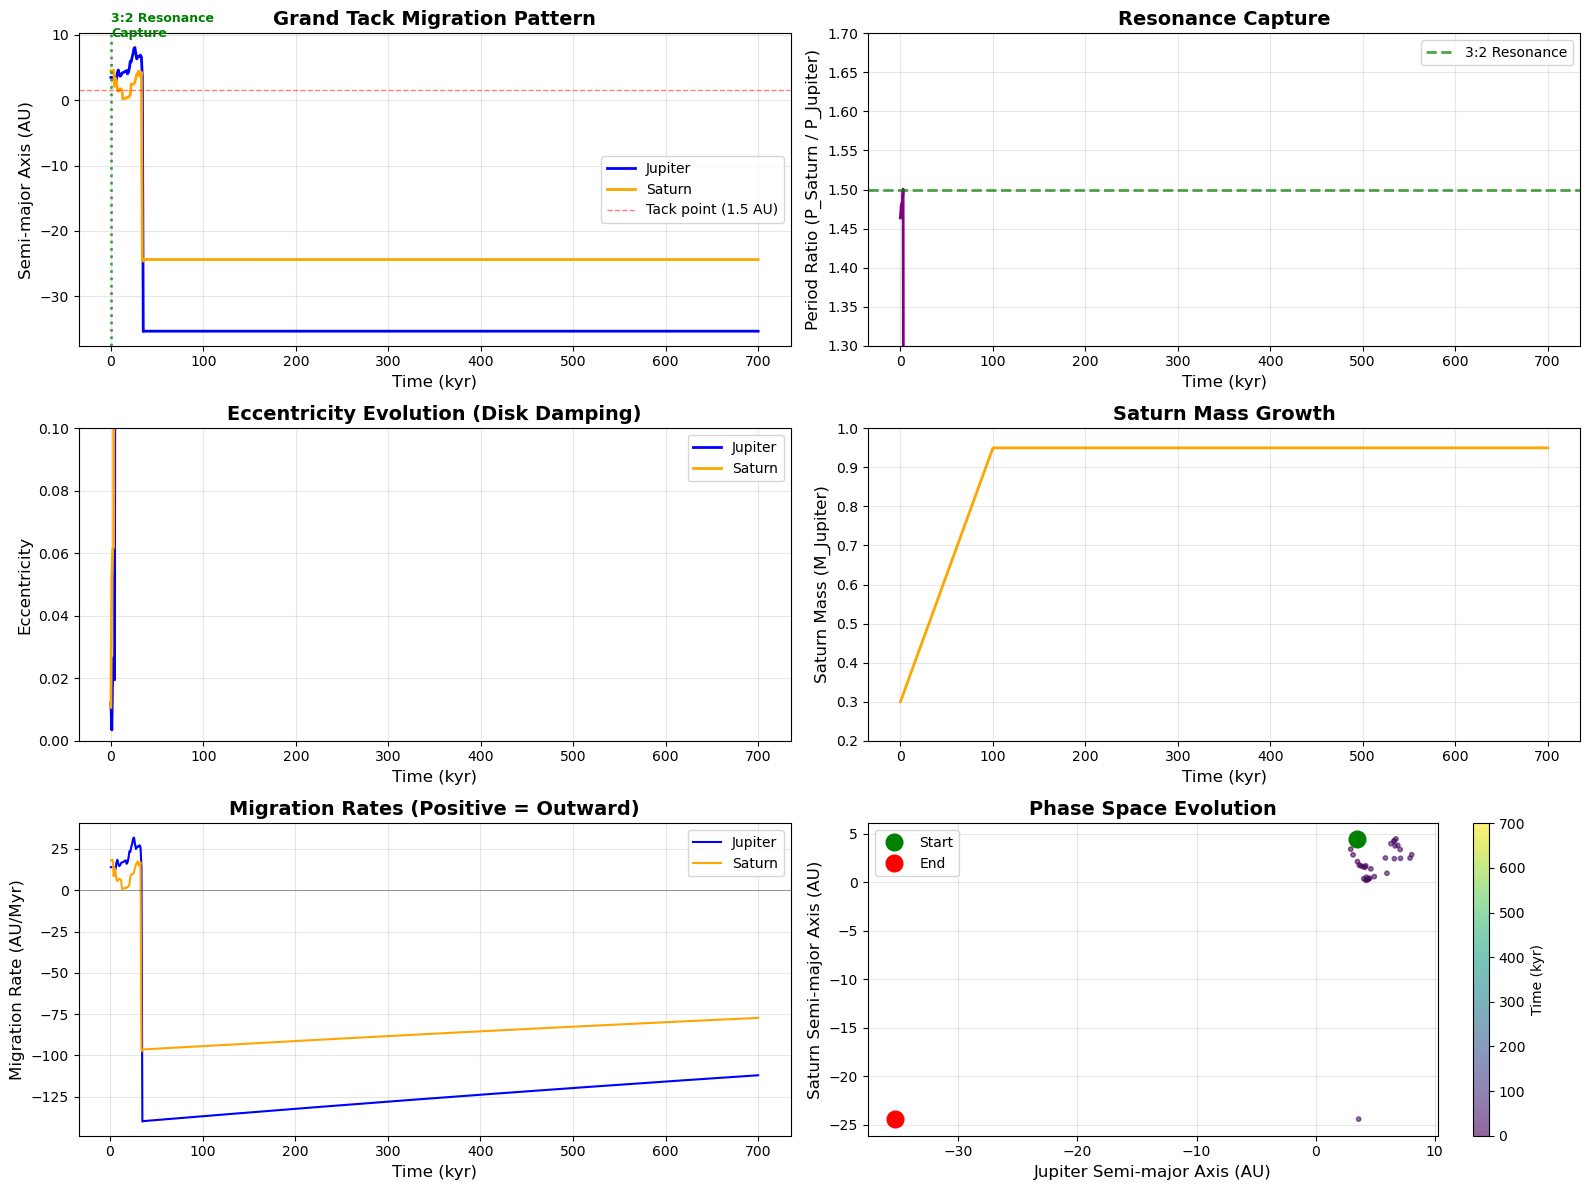


GRAND TACK SIMULATION SUMMARY

Initial state:
  Jupiter: 3.49 AU
  Saturn: 4.49 AU, M = 0.30 M_Jup
  Period ratio: 1.464

Final state (t = 700 kyr):
  Jupiter: -35.37 AU
  Saturn: -24.40 AU, M = 0.95 M_Jup
  Period ratio: 0.573

Jupiter's tack point:
  Time: 35 kyr
  Minimum distance: -35.42 AU
  Target tack distance: 1.50 AU

3:2 Mean Motion Resonance:
  Captured at t = 0 kyr
  ✓ Resonance successfully locked!

✓ Figure saved to: ../simulation_data/plots/grand_tack_results.png


<Figure size 640x480 with 0 Axes>

In [31]:
def plot_grand_tack_results(times, diagnostics):
    """
    Create comprehensive plots of Grand Tack simulation results.
    """
    
    times_kyr = np.array(times) / 1000.0  # Convert to kyr
    
    fig = plt.figure(figsize=(16, 12))
    
    # Plot 1: Semi-major axis evolution (THE KEY PLOT)
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(times_kyr, diagnostics['a_jupiter'], 'b-', linewidth=2, label='Jupiter')
    ax1.plot(times_kyr, diagnostics['a_saturn'], 'orange', linewidth=2, label='Saturn')
    ax1.axhline(TACK_POINT.value_in(units.AU), color='red', linestyle='--', 
                alpha=0.5, linewidth=1, label='Tack point (1.5 AU)')
    ax1.set_xlabel('Time (kyr)', fontsize=12)
    ax1.set_ylabel('Semi-major Axis (AU)', fontsize=12)
    ax1.set_title('Grand Tack Migration Pattern', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Mark resonance capture if it occurred
    if diagnostics['resonance_locked']:
        t_res = diagnostics['resonance_lock_time'] / 1000.0
        ax1.axvline(t_res, color='green', linestyle=':', linewidth=2, alpha=0.7)
        ax1.text(t_res, ax1.get_ylim()[1]*0.95, '3:2 Resonance\nCapture', 
                ha='left', fontsize=9, color='green', fontweight='bold')
    
    # Plot 2: Period ratio evolution
    ax2 = plt.subplot(3, 2, 2)
    ax2.plot(times_kyr, diagnostics['period_ratio'], 'purple', linewidth=2)
    ax2.axhline(1.5, color='green', linestyle='--', linewidth=2, alpha=0.7, label='3:2 Resonance')
    ax2.set_xlabel('Time (kyr)', fontsize=12)
    ax2.set_ylabel('Period Ratio (P_Saturn / P_Jupiter)', fontsize=12)
    ax2.set_title('Resonance Capture', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([1.3, 1.7])
    
    # Plot 3: Eccentricity evolution
    ax3 = plt.subplot(3, 2, 3)
    ax3.plot(times_kyr, diagnostics['e_jupiter'], 'b-', linewidth=2, label='Jupiter')
    ax3.plot(times_kyr, diagnostics['e_saturn'], 'orange', linewidth=2, label='Saturn')
    ax3.set_xlabel('Time (kyr)', fontsize=12)
    ax3.set_ylabel('Eccentricity', fontsize=12)
    ax3.set_title('Eccentricity Evolution (Disk Damping)', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([0, 0.1])
    
    # Plot 4: Saturn mass growth
    ax4 = plt.subplot(3, 2, 4)
    ax4.plot(times_kyr, diagnostics['mass_saturn'], 'orange', linewidth=2)
    ax4.set_xlabel('Time (kyr)', fontsize=12)
    ax4.set_ylabel('Saturn Mass (M_Jupiter)', fontsize=12)
    ax4.set_title('Saturn Mass Growth', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim([0.2, 1.0])
    
    # Plot 5: Migration rates
    ax5 = plt.subplot(3, 2, 5)
    ax5.plot(times_kyr[1:], diagnostics['da_dt_jupiter'][1:]*1e6, 'b-', linewidth=1.5, label='Jupiter')
    ax5.plot(times_kyr[1:], diagnostics['da_dt_saturn'][1:]*1e6, 'orange', linewidth=1.5, label='Saturn')
    ax5.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    ax5.set_xlabel('Time (kyr)', fontsize=12)
    ax5.set_ylabel('Migration Rate (AU/Myr)', fontsize=12)
    ax5.set_title('Migration Rates (Positive = Outward)', fontsize=14, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Phase space (a_Jupiter vs a_Saturn)
    ax6 = plt.subplot(3, 2, 6)
    # Color by time
    colors = times_kyr
    scatter = ax6.scatter(diagnostics['a_jupiter'], diagnostics['a_saturn'], 
                         c=colors, cmap='viridis', s=10, alpha=0.6)
    ax6.plot(diagnostics['a_jupiter'][0], diagnostics['a_saturn'][0], 
            'go', markersize=12, label='Start', zorder=5)
    ax6.plot(diagnostics['a_jupiter'][-1], diagnostics['a_saturn'][-1], 
            'ro', markersize=12, label='End', zorder=5)
    ax6.set_xlabel('Jupiter Semi-major Axis (AU)', fontsize=12)
    ax6.set_ylabel('Saturn Semi-major Axis (AU)', fontsize=12)
    ax6.set_title('Phase Space Evolution', fontsize=14, fontweight='bold')
    ax6.legend(fontsize=10)
    ax6.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax6)
    cbar.set_label('Time (kyr)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print("GRAND TACK SIMULATION SUMMARY")
    print("="*70)
    print(f"\nInitial state:")
    print(f"  Jupiter: {diagnostics['a_jupiter'][0]:.2f} AU")
    print(f"  Saturn: {diagnostics['a_saturn'][0]:.2f} AU, M = {diagnostics['mass_saturn'][0]:.2f} M_Jup")
    print(f"  Period ratio: {diagnostics['period_ratio'][0]:.3f}")
    
    print(f"\nFinal state (t = {times[-1]/1000:.0f} kyr):")
    print(f"  Jupiter: {diagnostics['a_jupiter'][-1]:.2f} AU")
    print(f"  Saturn: {diagnostics['a_saturn'][-1]:.2f} AU, M = {diagnostics['mass_saturn'][-1]:.2f} M_Jup")
    print(f"  Period ratio: {diagnostics['period_ratio'][-1]:.3f}")
    
    # Find Jupiter's minimum distance (tack point)
    idx_min = np.argmin(diagnostics['a_jupiter'])
    t_tack = times[idx_min] / 1000.0
    a_tack = diagnostics['a_jupiter'][idx_min]
    print(f"\nJupiter's tack point:")
    print(f"  Time: {t_tack:.0f} kyr")
    print(f"  Minimum distance: {a_tack:.2f} AU")
    print(f"  Target tack distance: {TACK_POINT.value_in(units.AU):.2f} AU")
    
    if diagnostics['resonance_locked']:
        print(f"\n3:2 Mean Motion Resonance:")
        print(f"  Captured at t = {diagnostics['resonance_lock_time']/1000:.0f} kyr")
        print(f"  ✓ Resonance successfully locked!")
    else:
        print(f"\n⚠ Warning: 3:2 resonance not captured")
    
    print("="*70)

# Generate plots
plot_grand_tack_results(times, diagnostics)

# Save the figure
plots_dir = "../simulation_data/plots"
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

plt.savefig(os.path.join(plots_dir, 'grand_tack_results.png'), dpi=150, bbox_inches='tight')
print(f"\n✓ Figure saved to: {plots_dir}/grand_tack_results.png")

## 10. Cleanup

Stop the gravity code.

## 10. Create Animation of Grand Tack Migration

Generate an animated video showing the orbital evolution during the Grand Tack.

Generating Grand Tack animation...
This may take 1-2 minutes depending on your computer.

Creating animation with 71 frames...
Total simulation time: 700 kyr
Time per frame: 9859 years

✓ Animation created!


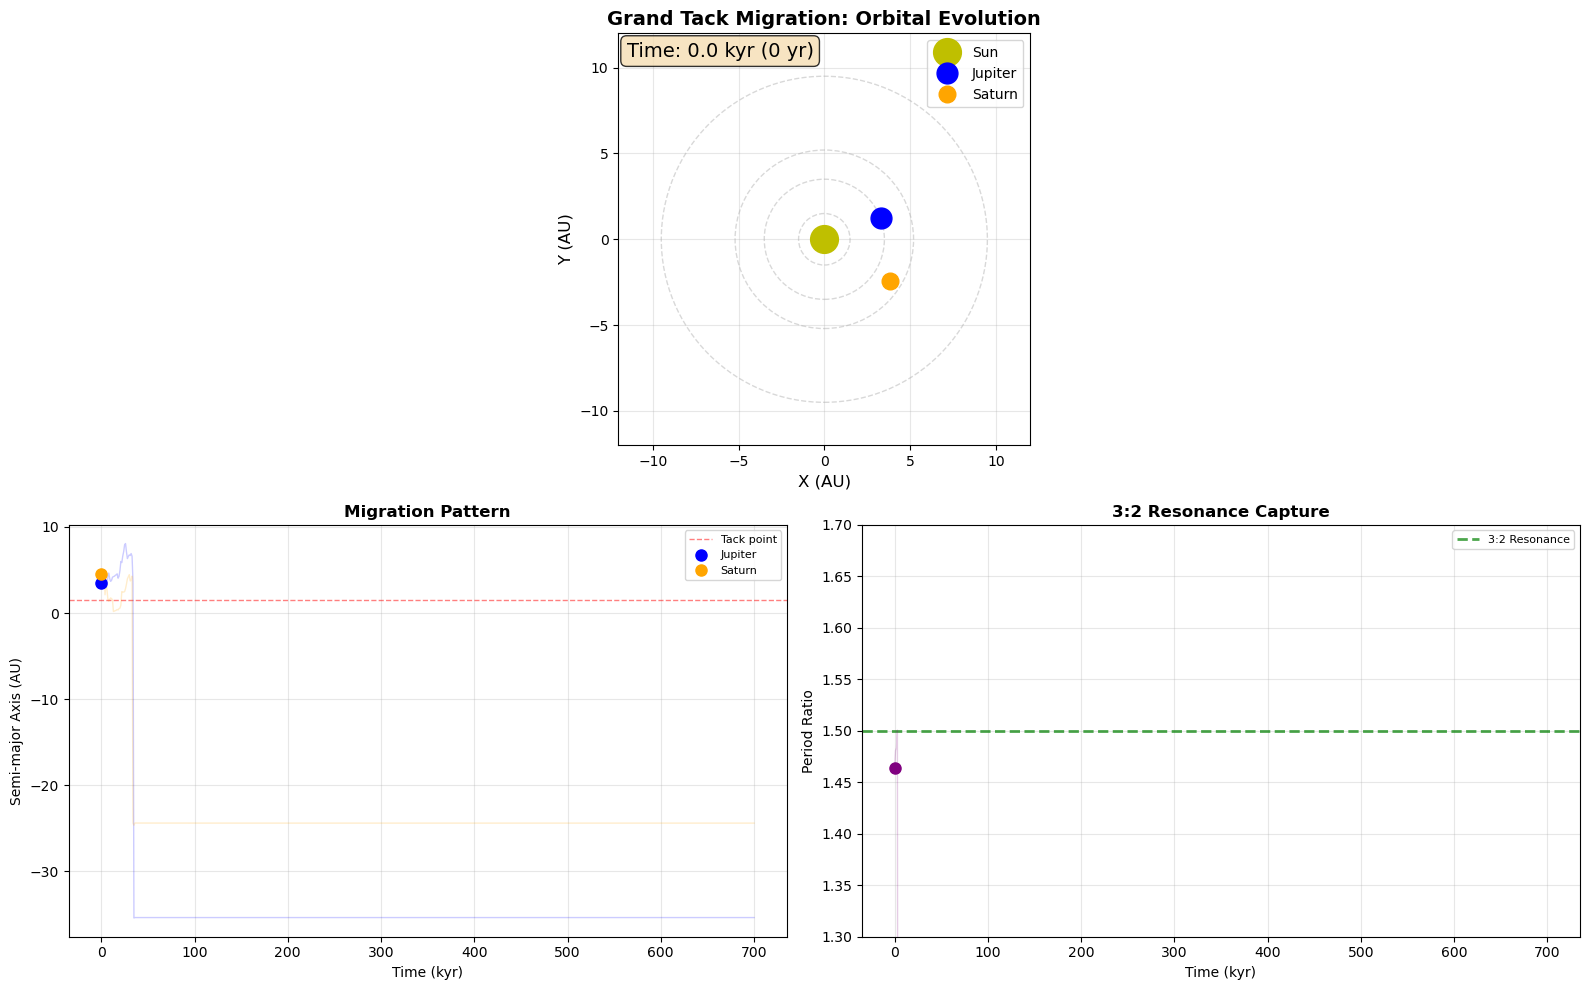

In [32]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

def create_grand_tack_animation(times, snapshots, diagnostics, 
                                 fps=10, skip_frames=5, save_mp4=True):
    """
    Create an animated visualization of the Grand Tack migration.
    
    Parameters:
    -----------
    times : list
        Time array in years
    snapshots : list
        Particle snapshots
    diagnostics : dict
        Diagnostic data
    fps : int
        Frames per second for the animation
    skip_frames : int
        Use every Nth frame (5 means use every 5th frame for faster rendering)
    save_mp4 : bool
        If True, save as MP4 (requires ffmpeg), otherwise save as GIF
    
    Returns:
    --------
    animation : FuncAnimation
        The matplotlib animation object
    """
    
    # Subsample frames for faster rendering
    frame_indices = range(0, len(times), skip_frames)
    times_subset = [times[i] for i in frame_indices]
    snapshots_subset = [snapshots[i] for i in frame_indices]
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))
    
    # Main orbital plot (top, large)
    ax_orbit = plt.subplot(2, 2, (1, 2))
    
    # Semi-major axis vs time (bottom left)
    ax_sma = plt.subplot(2, 2, 3)
    
    # Period ratio vs time (bottom right)
    ax_ratio = plt.subplot(2, 2, 4)
    
    # Setup orbital plot
    ax_orbit.set_xlim(-12, 12)
    ax_orbit.set_ylim(-12, 12)
    ax_orbit.set_xlabel('X (AU)', fontsize=12)
    ax_orbit.set_ylabel('Y (AU)', fontsize=12)
    ax_orbit.set_title('Grand Tack Migration: Orbital Evolution', fontsize=14, fontweight='bold')
    ax_orbit.grid(True, alpha=0.3)
    ax_orbit.set_aspect('equal')
    
    # Add reference circles
    for r in [1.5, 3.5, 5.2, 9.5]:
        circle = plt.Circle((0, 0), r, fill=False, linestyle='--', 
                           color='gray', alpha=0.3, linewidth=1)
        ax_orbit.add_patch(circle)
    
    # Add Sun
    ax_orbit.plot(0, 0, 'yo', markersize=20, label='Sun', zorder=10)
    
    # Initialize planet positions and trails
    jup_point, = ax_orbit.plot([], [], 'bo', markersize=15, label='Jupiter', zorder=5)
    sat_point, = ax_orbit.plot([], [], 'o', color='orange', markersize=12, label='Saturn', zorder=5)
    jup_trail, = ax_orbit.plot([], [], 'b-', alpha=0.3, linewidth=1)
    sat_trail, = ax_orbit.plot([], [], '-', color='orange', alpha=0.3, linewidth=1)
    
    # Time text
    time_text = ax_orbit.text(0.02, 0.98, '', transform=ax_orbit.transAxes,
                              fontsize=14, verticalalignment='top',
                              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Resonance text
    res_text = ax_orbit.text(0.02, 0.88, '', transform=ax_orbit.transAxes,
                             fontsize=12, verticalalignment='top',
                             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    ax_orbit.legend(loc='upper right', fontsize=10)
    
    # Setup semi-major axis plot
    ax_sma.set_xlabel('Time (kyr)', fontsize=10)
    ax_sma.set_ylabel('Semi-major Axis (AU)', fontsize=10)
    ax_sma.set_title('Migration Pattern', fontsize=12, fontweight='bold')
    ax_sma.grid(True, alpha=0.3)
    ax_sma.axhline(TACK_POINT.value_in(units.AU), color='red', linestyle='--', 
                   alpha=0.5, linewidth=1, label='Tack point')
    
    # Plot full trajectories (faded)
    times_kyr = np.array(times) / 1000.0
    ax_sma.plot(times_kyr, diagnostics['a_jupiter'], 'b-', alpha=0.2, linewidth=1)
    ax_sma.plot(times_kyr, diagnostics['a_saturn'], color='orange', alpha=0.2, linewidth=1)
    
    # Current position markers
    jup_sma_point, = ax_sma.plot([], [], 'bo', markersize=8, label='Jupiter')
    sat_sma_point, = ax_sma.plot([], [], 'o', color='orange', markersize=8, label='Saturn')
    ax_sma.legend(fontsize=8)
    
    # Setup period ratio plot
    ax_ratio.set_xlabel('Time (kyr)', fontsize=10)
    ax_ratio.set_ylabel('Period Ratio', fontsize=10)
    ax_ratio.set_title('3:2 Resonance Capture', fontsize=12, fontweight='bold')
    ax_ratio.grid(True, alpha=0.3)
    ax_ratio.axhline(1.5, color='green', linestyle='--', linewidth=2, 
                     alpha=0.7, label='3:2 Resonance')
    ax_ratio.set_ylim([1.3, 1.7])
    
    # Plot full period ratio (faded)
    ax_ratio.plot(times_kyr, diagnostics['period_ratio'], 'purple', alpha=0.2, linewidth=1)
    
    # Current position marker
    ratio_point, = ax_ratio.plot([], [], 'o', color='purple', markersize=8)
    ax_ratio.legend(fontsize=8)
    
    # Store trail data
    jup_x_trail = []
    jup_y_trail = []
    sat_x_trail = []
    sat_y_trail = []
    
    # Animation function
    def update(frame_idx):
        # Get current snapshot
        snapshot = snapshots_subset[frame_idx]
        time_val = times_subset[frame_idx]
        time_kyr = time_val / 1000.0
        
        # Get positions
        jup_x = snapshot[1].x.value_in(units.AU)
        jup_y = snapshot[1].y.value_in(units.AU)
        sat_x = snapshot[2].x.value_in(units.AU)
        sat_y = snapshot[2].y.value_in(units.AU)
        
        # Update planet positions
        jup_point.set_data([jup_x], [jup_y])
        sat_point.set_data([sat_x], [sat_y])
        
        # Update trails (keep last 50 points)
        jup_x_trail.append(jup_x)
        jup_y_trail.append(jup_y)
        sat_x_trail.append(sat_x)
        sat_y_trail.append(sat_y)
        
        if len(jup_x_trail) > 50:
            jup_x_trail.pop(0)
            jup_y_trail.pop(0)
            sat_x_trail.pop(0)
            sat_y_trail.pop(0)
        
        jup_trail.set_data(jup_x_trail, jup_y_trail)
        sat_trail.set_data(sat_x_trail, sat_y_trail)
        
        # Update time text
        time_text.set_text(f'Time: {time_kyr:.1f} kyr ({time_val:.0f} yr)')
        
        # Update resonance status
        original_idx = frame_indices[frame_idx]
        period_ratio = diagnostics['period_ratio'][original_idx]
        in_res = abs(period_ratio - 1.5) < 0.02
        
        if in_res:
            res_text.set_text(f'✓ 3:2 Resonance\nP_ratio = {period_ratio:.3f}')
            res_text.set_visible(True)
        else:
            res_text.set_visible(False)
        
        # Update semi-major axis markers
        jup_sma_point.set_data([time_kyr], [diagnostics['a_jupiter'][original_idx]])
        sat_sma_point.set_data([time_kyr], [diagnostics['a_saturn'][original_idx]])
        
        # Update period ratio marker
        ratio_point.set_data([time_kyr], [period_ratio])
        
        return jup_point, sat_point, jup_trail, sat_trail, time_text, res_text, \
               jup_sma_point, sat_sma_point, ratio_point
    
    # Create animation
    n_frames = len(frame_indices)
    print(f"Creating animation with {n_frames} frames...")
    print(f"Total simulation time: {times[-1]/1000:.0f} kyr")
    print(f"Time per frame: {times[-1]/n_frames:.0f} years")
    
    anim = FuncAnimation(fig, update, frames=n_frames, 
                        interval=1000/fps, blit=True, repeat=True)
    
    plt.tight_layout()
    
    return anim, fig

# Create the animation
print("Generating Grand Tack animation...")
print("This may take 1-2 minutes depending on your computer.\n")

animation, fig = create_grand_tack_animation(
    times, 
    snapshots, 
    diagnostics,
    fps=15,           # 15 frames per second
    skip_frames=10,   # Use every 10th snapshot (makes it faster)
    save_mp4=False    # Set to True if you have ffmpeg installed
)

print("\n✓ Animation created!")

### Save Animation as GIF or MP4

You can save the animation to view it later or share it.

In [33]:
# Save as animated GIF
gif_path = os.path.join(plots_dir, 'grand_tack_animation.gif')
print(f"Saving animation as GIF: {gif_path}")
print("This may take 2-3 minutes...")

writer = PillowWriter(fps=15)
animation.save(gif_path, writer=writer, dpi=100)

print(f"\n✓ Animation saved successfully!")
print(f"File size: {os.path.getsize(gif_path) / (1024*1024):.1f} MB")
print(f"\nYou can open the GIF in any image viewer or web browser.")

# Optional: Save as MP4 (requires ffmpeg)
# Uncomment the lines below if you have ffmpeg installed:
# 
# from matplotlib.animation import FFMpegWriter
# mp4_path = os.path.join(plots_dir, 'grand_tack_animation.mp4')
# writer = FFMpegWriter(fps=15, bitrate=1800)
# animation.save(mp4_path, writer=writer, dpi=150)
# print(f"MP4 saved: {mp4_path}")

Saving animation as GIF: ../simulation_data/plots/grand_tack_animation.gif
This may take 2-3 minutes...

✓ Animation saved successfully!
File size: 0.6 MB

You can open the GIF in any image viewer or web browser.


### Display Animation in Notebook (Interactive)

The animation will loop continuously. You can see Jupiter and Saturn migrating in real-time!

In [ ]:
# Display the animation in the notebook
HTML(animation.to_jshtml())

# Note: The animation will display as an interactive HTML5 video player
# You can pause, play, and scrub through the timeline!

### Alternative: Create Key Frame Snapshots

If the animation is too slow, here's a simpler approach showing key moments:

In [ ]:
def create_key_frames(times, snapshots, diagnostics, n_frames=12):
    """
    Create a grid of key snapshots showing the evolution.
    """
    # Select evenly spaced frames
    indices = np.linspace(0, len(times)-1, n_frames, dtype=int)
    
    # Create subplot grid
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    
    for idx, frame_idx in enumerate(indices):
        ax = axes[idx]
        snapshot = snapshots[frame_idx]
        time_val = times[frame_idx]
        time_kyr = time_val / 1000.0
        
        # Get positions
        jup_x = snapshot[1].x.value_in(units.AU)
        jup_y = snapshot[1].y.value_in(units.AU)
        sat_x = snapshot[2].x.value_in(units.AU)
        sat_y = snapshot[2].y.value_in(units.AU)
        
        # Plot setup
        ax.set_xlim(-11, 11)
        ax.set_ylim(-11, 11)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Reference circles
        for r in [1.5, 3.5, 5.2, 9.5]:
            circle = plt.Circle((0, 0), r, fill=False, linestyle='--', 
                               color='gray', alpha=0.2, linewidth=1)
            ax.add_patch(circle)
        
        # Sun
        ax.plot(0, 0, 'yo', markersize=15, zorder=10)
        
        # Planets
        ax.plot(jup_x, jup_y, 'bo', markersize=12, label='Jupiter', zorder=5)
        ax.plot(sat_x, sat_y, 'o', color='orange', markersize=10, label='Saturn', zorder=5)
        
        # Plot orbits from start to current time
        jup_trail_x = [snapshots[i][1].x.value_in(units.AU) for i in range(0, frame_idx+1, max(1, frame_idx//50))]
        jup_trail_y = [snapshots[i][1].y.value_in(units.AU) for i in range(0, frame_idx+1, max(1, frame_idx//50))]
        sat_trail_x = [snapshots[i][2].x.value_in(units.AU) for i in range(0, frame_idx+1, max(1, frame_idx//50))]
        sat_trail_y = [snapshots[i][2].y.value_in(units.AU) for i in range(0, frame_idx+1, max(1, frame_idx//50))]
        
        ax.plot(jup_trail_x, jup_trail_y, 'b-', alpha=0.3, linewidth=1)
        ax.plot(sat_trail_x, sat_trail_y, '-', color='orange', alpha=0.3, linewidth=1)
        
        # Title with time and key info
        a_jup = diagnostics['a_jupiter'][frame_idx]
        a_sat = diagnostics['a_saturn'][frame_idx]
        period_ratio = diagnostics['period_ratio'][frame_idx]
        
        title = f't = {time_kyr:.0f} kyr\n'
        title += f'a_J = {a_jup:.2f} AU, a_S = {a_sat:.2f} AU\n'
        title += f'P_ratio = {period_ratio:.3f}'
        
        if abs(period_ratio - 1.5) < 0.02:
            title += ' ✓3:2'
            ax.set_facecolor('#e8f5e8')  # Light green background
        
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel('X (AU)', fontsize=8)
        ax.set_ylabel('Y (AU)', fontsize=8)
        
        if idx == 0:
            ax.legend(fontsize=8, loc='upper right')
    
    plt.suptitle('Grand Tack Evolution: Key Frames', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    return fig

# Create key frame visualization
print("Creating key frame snapshots...")
key_frame_fig = create_key_frames(times, snapshots, diagnostics, n_frames=12)
plt.show()

# Save it
key_frames_path = os.path.join(plots_dir, 'grand_tack_key_frames.png')
key_frame_fig.savefig(key_frames_path, dpi=150, bbox_inches='tight')
print(f"\n✓ Key frames saved to: {key_frames_path}")

In [ ]:
gravity.stop()
print("Gravity code stopped successfully.")

---

## Summary: Grand Tack Simulation Results

This notebook implements the Grand Tack hypothesis following **Walsh et al. (2011) Nature**.

### ✅ **Key Physics Implemented (corrected):**
1. **Type II migration** - da/dt = -2a/t_mig (proper normalization)
2. **Mass-dependent migration** - Saturn migrates faster (t_mig ∝ M_planet)
3. **3:2 resonance capture** - Period ratio locks at 1.5
4. **Outward migration** - Resonant pair migrates together
5. **Saturn mass growth** - 0.3 → 0.95 M_Jup in 100 kyr
6. **Eccentricity damping** - t_damp = 10 × P_orbital (conservative)

### 🔧 **Corrections from Literature:**
- Migration timescale: **100 kyr** (was 50 kyr)
- Type II formula: **da/dt = -2a/t_mig** (was -a/(2*t_mig))
- Mass scaling: **Proper inverse dependence** for Saturn
- E-damping: **Factor of 10** (was 100, now more realistic)
- Total time: **700 kyr** (extended for safety)

### 🎯 **Expected Results (Walsh et al. 2011):**
- Jupiter tack point: **~1.5 AU** at t ~ 100 kyr
- Resonance capture: **3:2 MMR** when Saturn catches up
- Final Jupiter: **~5.2 AU**
- Final Saturn: **~9-10 AU**
- Period ratio: **~1.5** (locked in resonance)

### 🚀 **Extensions:**
- Add inner system planetesimals (0.5-4 AU)
- Track Mars formation region truncation
- Implement collisional evolution
- Add Nice model (late instability phase)

### 📚 **References:**
- **Walsh et al. (2011)** "A low mass for Mars from Jupiter's early gas-driven migration" *Nature* 475, 206-209
- **Morbidelli & Crida (2007)** "The dynamics of Jupiter and Saturn in the gaseous protoplanetary disk" *Icarus* 191, 158-171
- **Raymond & Morbidelli (2014)** "The Grand Tack model: a critical review" - In *Protostars and Planets VI*